# MSC_DA_CA1_Semester_2:
# A Comparative Study of VGG16 and EfficientNet for Potato Leaf Disease Detection: An Integration of Hadoop and Apache Spark

**Name:**
Madina Sagatova

**Student ID:**
2021255

**Student email:**
2021255@student.cct.ie

**Programme Title:**
MSc in Data Analytics

### Loading Image Dataset with PySpark

In [1]:
from pyspark.sql import SparkSession

# Create a Spark session 
spark = SparkSession.builder.appName('PotatoLeafDiseas').getOrCreate()

# Loading the images from HDFS 
data = spark.read.format('image').load('hdfs://localhost:9000/user1/potato_disease/*')

# Displaying schema to ensure the data is loaded correctly 
data.printSchema()

# Show some sample data
data.show()

24/09/29 18:24:23 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



+--------------------+
|               image|
+--------------------+
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
+--------------------+
only showing top 20 rows



### Label & Preprocess Data 

In [2]:
from pyspark.sql.functions import regexp_extract, col

# Add a label column based on the 3 folder names: Potato___Early_blight, Potato___healthy, Potato___Late_blight
data = data.withColumn('label',regexp_extract(col('image.origin'), 'potato_disease/([^/]+)', 1))

# Show some labeled data
data.select('image.origin', 'label').show(15)

+--------------------+--------------------+
|              origin|               label|
+--------------------+--------------------+
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
+--------------------+--------------------+
only showing top 15 rows



### Display Original Images before Resizing 

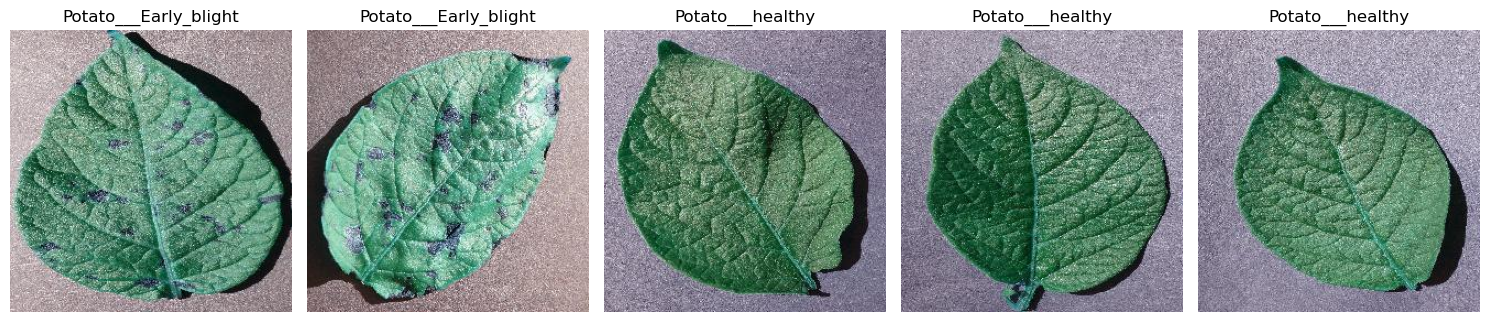

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display an image - takes a list of img data and their corresponding titles
def display_images(image_data_list, heights, widths, nChannels, titles=None):
    plt.figure(figsize=(15,10)) # set fig size
    
    for i in range(len(image_data_list)):
        plt.subplot(1, len(image_data_list), i + 1) # create subplot for each img
        # convert binary image data to a numpy array
        image_array = np.frombuffer(image_data_list[i], np.uint8).reshape((heights[i],
                                                               widths[i],
                                                               nChannels
                                                               ))
        # Display the img
        plt.imshow(image_array)
        if titles:
            plt.title(titles[i]) # set the title if provided
        plt.axis('off') # hide axes
        
    plt.tight_layout() # adjust spacing between subplots
    plt.show()
    
# Sample of 5 rows from the DF
sample_images = data.take(5) # the first 5 rows

# List for img data, heights, widths and titles 
image_data_list = []
heights = []
widths = []
titles =[]

for row in sample_images:
    image_data_list.append(row['image']['data'])
    heights.append(row['image']['height'])
    widths.append(row['image']['width'])
    titles.append(row['label']) # display the label for the title 

    
# Display the img
display_images(image_data_list, heights, widths, sample_images[0]['image']['nChannels'], titles)


### Label Encoding 

In [4]:
from pyspark.ml.feature import StringIndexer

# Initialize StringIndexer to convert labels into numerical values
indexer = StringIndexer(inputCol='label', outputCol='labelIndex')

# Fit and Transform the DF
data = indexer.fit(data).transform(data)

# Show the data to verify label encoding 
data.select('label', 'labelIndex').show(5)

+--------------------+----------+
|               label|labelIndex|
+--------------------+----------+
|Potato___Early_bl...|       0.0|
|Potato___Early_bl...|       0.0|
|    Potato___healthy|       2.0|
|    Potato___healthy|       2.0|
|    Potato___healthy|       2.0|
+--------------------+----------+
only showing top 5 rows



### Image Resizing & Normalization 

In [8]:
# Import an OpenCV library
import cv2
# Import Row
from pyspark.sql import Row


# Function to convert the binary data into NumPy arrays, resize the imgs, and then normalize them
def resize_and_normalize_image(row, new_size=(224, 224)):
    # convert bynary data into a numpy array, use reshape it to the original dimensions
    image_data = np.frombuffer(row.image.data, dtype=np.uint8).reshape(
    (row.image.height, row.image.width, row.image.nChannels))
    # resize the image using OpenCV
    resized_image = cv2.resize(image_data, new_size)
    # print Original size and Resized size for ensuring the changes 
    print(f'Original size: {image_data.shape}, Resized size: {resized_image.shape}')
    # normalize the pixels to the range - [0, 1]
    normalized_image = resized_image.astype('float32') / 255.0
    return normalized_image.tolist()

#Apply the function to resize & normalize all images
resized_normalized_rdd = data.rdd.map(lambda row: Row(image=resize_and_normalize_image(row), labelIndex=row.label))

resized_normalized_df = resized_normalized_rdd.toDF()

# Show the resized and normalized DF schema to verufy the changes
resized_normalized_df.printSchema()
resized_normalized_df.show()

Original size: (256, 256, 3), Resized size: (224, 224, 3)           (0 + 1) / 1]


root
 |-- image: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)
 |-- labelIndex: string (nullable = true)



Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)           (0 + 1) / 1]
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224,

+--------------------+--------------------+
|               image|          labelIndex|
+--------------------+--------------------+
|[[[0.729411780834...|Potato___Early_bl...|
|[[[0.564705908298...|Potato___Early_bl...|
|[[[0.541176497936...|    Potato___healthy|
|[[[0.588235318660...|    Potato___healthy|
|[[[0.607843160629...|    Potato___healthy|
|[[[0.725490212440...|Potato___Early_bl...|
|[[[0.725490212440...|    Potato___healthy|
|[[[0.576470613479...|    Potato___healthy|
|[[[0.454901963472...|Potato___Early_bl...|
|[[[0.568627476692...|    Potato___healthy|
|[[[0.682352960109...|    Potato___healthy|
|[[[0.462745100259...|    Potato___healthy|
|[[[0.792156875133...|Potato___Early_bl...|
|[[[0.517647087574...|Potato___Early_bl...|
|[[[0.509803950786...|    Potato___healthy|
|[[[0.709803938865...|    Potato___healthy|
|[[[0.776470601558...|Potato___Early_bl...|
|[[[0.815686285495...|Potato___Early_bl...|
|[[[0.596078455448...|    Potato___healthy|
|[[[0.678431391716...|Potato___E

###

Original size: (256, 256, 3), Resized size: (224, 224, 3)           (0 + 1) / 1]
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
Original size: (256, 256, 3), Resized size: (224, 224, 3)
24/09/29 18:47:06 ERROR Executor: Exception in task 0.0 in stage 9.0 (TID 75)
org.apache.spark.api.python.P

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 9.0 failed 1 times, most recent failure: Lost task 0.0 in stage 9.0 (TID 75) (10.0.2.15 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/pyspark/rdd.py", line 2830, in takeUpToNumLeft
    yield next(iterator)
          ^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_5014/2187923706.py", line 4, in normalize_image
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:179)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2303)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2790)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2726)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2725)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2725)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1211)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1211)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1211)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2989)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2928)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2917)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:976)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:179)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/pyspark/rdd.py", line 2830, in takeUpToNumLeft
    yield next(iterator)
          ^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_5014/2187923706.py", line 4, in normalize_image
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:179)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2303)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
